# **U-Net for Nuclei Segmentation in Microscopic Images**
---

## **Overview**
>This notebook demonstrates the process of nuclei segmentation in microscopy images using the U-Net deep learning architecture. The dataset is derived from the 2018 Data Science Bowl, featuring training and testing images with corresponding masks that indicate nuclei locations. The notebook outlines data preprocessing, building the U-Net model, training it for segmentation, and evaluating its performance. The U-Net, a powerful convolutional neural network for biomedical image segmentation, employs an encoder-decoder structure with skip connections, making it ideal for this task. Visualization of predictions and training metrics is included for better insight into the model's learning process.

## **Installing Kaggle and Uploading API Token**
>Install the Kaggle library, upload the Kaggle API token (kaggle.json), and configure it for downloading datasets.
 - Upload `kaggle.json`.
 - Move the file to the correct location (`~/.kaggle`) and set appropriate permissions.

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syedalinaqvi","key":"605c23dd07a7a352fbd0f39a5e8b690a"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c data-science-bowl-2018

 99% 353M/358M [00:05<00:00, 85.3MB/s]
100% 358M/358M [00:05<00:00, 74.8MB/s]


## **Importing Libraries**
>Essential libraries are imported for image processing, data handling, and model development.

In [5]:
import os
import random
import numpy as np
import tensorflow as tf
import zipfile
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

## **Downloading and Extracting Dataset**
>Download the Data Science Bowl 2018 dataset and extract its contents.
 - Download the dataset using Kaggle API.
 - Extract the main dataset and its components (`stage1_train.zip` and `stage1_test.zip`).

In [7]:
with zipfile.ZipFile("/content/data-science-bowl-2018.zip", "r") as zip:
  zip.extractall("Cell Images")
  print("Done")

with zipfile.ZipFile("/content/Cell Images/stage1_train.zip", "r") as zip:
  zip.extractall("Stage 1 Train Images")
  print("Done")

with zipfile.ZipFile("/content/Cell Images/stage1_test.zip", "r") as zip:
  zip.extractall("Stage 1 Test Images")
  print("Done")

Done
Done
Done


## **Dataset Paths and Image Dimensions**
>Define constants for dataset paths and image dimensions for resizing.
 - `TRAIN_PATH` and `TEST_PATH`: Paths to training and testing datasets.
 - `IMG_WIDTH`, `IMG_HEIGHT`, `IMG_CHANNELS`: Resize all images to 128x128 pixels with 3 color channels.

In [8]:
TRAIN_PATH = "/content/Stage 1 Train Images/"
TEST_PATH = "/content/Stage 1 Test Images/"

In [9]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

## ** Preparing Training Data**
>Resize images and create masks for training data.
 - Loop through each training image folder.
 - Read and resize images to match defined dimensions.
 - Create a combined binary mask for each image from all associated mask files.
  - `X_train`: Training images array.
  - `y_train`: Binary masks corresponding to training images.

In [10]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [11]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [12]:
print("Resizing training images and masks...\n\n")

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + "/images/" + id_ + ".png")[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    for mask_file in next(os.walk(path + "/masks/"))[2]:
        mask_ = imread(path + "/masks/" + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    y_train[n] = mask

Resizing training images and masks...




100%|██████████| 670/670 [04:31<00:00,  2.47it/s]


## **Preparing Test Data**
>Resize test images.
 - Loop through each test image folder.
 - Read and resize images.
 - Store original dimensions for resizing predictions back.
  - `X_test`: Resized test images.
  - `sizes_test`: Original test image dimensions.

In [13]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

In [14]:
print("Resizing test images...\n\n")

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + "/images/" + id_ + ".png")[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Resizing test images...




100%|██████████| 65/65 [00:02<00:00, 23.42it/s]


## **Visualizing Data**
>Randomly visualize a training image and its corresponding mask.
- `matplotlib.pyplot` for displaying images.


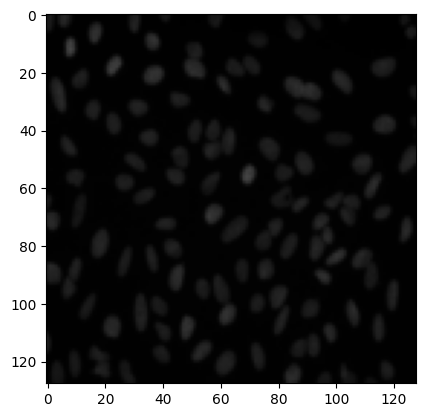

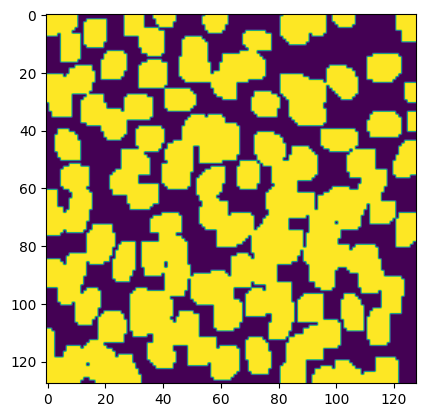

In [15]:
image_x = random.randint(0, len(train_ids))
plt.imshow(X_train[image_x])
plt.show();

plt.imshow(np.squeeze(y_train[image_x]))
plt.show();

## **U-Net Model Construction**
>Build a U-Net model for image segmentation.
 - Input Layer: Accepts images of size (128x128x3).
 - Rescaling: Normalizes input values to the range [0, 1].
 - Encoder Path (Contraction):
  - Four blocks of Conv2D → Dropout → Conv2D → MaxPooling2D.
  - Gradually increases filters (16 → 32 → 64 → 128 → 256).
  - Captures spatial features while reducing image dimensions.
 - Bottleneck:
  - Two Conv2D layers with 256 filters and dropout.
 - Decoder Path (Expansion):
  - Four blocks of Conv2DTranspose → Concatenate → Conv2D → Dropout → Conv2D.
  - Gradually decreases filters (256 → 128 → 64 → 32 → 16).
  - Restores spatial dimensions by concatenating encoder outputs.
 - Output Layer:
  - A Conv2D layer with a single filter and sigmoid activation for binary segmentation.
 - Model Compilation:
  - Optimizer: Adam.
  - Loss: Binary crossentropy.
  - Metric: Accuracy.

In [16]:
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
normalized_inputs = tf.keras.layers.Rescaling(1.0 / 255)(inputs)

# Encoder path
conv1_1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(normalized_inputs)
drop1_1 = tf.keras.layers.Dropout(0.1)(conv1_1)
conv2_1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1_1)
pool1_1 = tf.keras.layers.MaxPooling2D((2, 2))(conv2_1)

conv1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1_1)
drop1_2 = tf.keras.layers.Dropout(0.1)(conv1_2)
conv2_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1_2)
pool1_2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2_2)

conv1_3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1_2)
drop1_3 = tf.keras.layers.Dropout(0.2)(conv1_3)
conv2_3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1_3)
pool1_3 = tf.keras.layers.MaxPooling2D((2, 2))(conv2_3)

conv1_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1_3)
drop1_4 = tf.keras.layers.Dropout(0.2)(conv1_4)
conv2_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1_4)
pool1_4 = tf.keras.layers.MaxPooling2D((2, 2))(conv2_4)

conv1_5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1_4)
drop1_5 = tf.keras.layers.Dropout(0.3)(conv1_5)
conv2_5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1_5)

# Decoder path
up1_1 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv2_5)
up1_1 = tf.keras.layers.concatenate([up1_1, conv2_4])
conv1_6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up1_1)
drop1_6 = tf.keras.layers.Dropout(0.2)(conv1_6)
conv2_6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1_6)

up1_2 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv2_6)
up1_2 = tf.keras.layers.concatenate([up1_2, conv2_3])
conv1_7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up1_2)
drop1_7 = tf.keras.layers.Dropout(0.2)(conv1_7)
conv2_7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1_7)

up1_3 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_7)
up1_3 = tf.keras.layers.concatenate([up1_3, conv2_2])
conv1_8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up1_3)
drop1_8 = tf.keras.layers.Dropout(0.1)(conv1_8)
conv2_8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1_8)

up1_4 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv2_8)
up1_4 = tf.keras.layers.concatenate([up1_4, conv2_1])
conv1_9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up1_4)
drop1_9 = tf.keras.layers.Dropout(0.1)(conv1_9)
conv2_9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1_9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv2_9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## **Model Summary**
>Display the architecture and parameter count of the U-Net model.

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.keras', verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='log_dir')
]

## **Training the Model**
>Train the U-Net model.
 - Use early stopping and model checkpointing.
 - Train for a maximum of 25 epochs with a batch size of 16.


In [20]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    batch_size=16,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 548ms/step - accuracy: 0.7432 - loss: 0.6333 - val_accuracy: 0.7716 - val_loss: 0.4624
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8286 - loss: 0.3208 - val_accuracy: 0.9081 - val_loss: 0.2313
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9252 - loss: 0.1979 - val_accuracy: 0.9347 - val_loss: 0.1656
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9412 - loss: 0.1534 - val_accuracy: 0.9458 - val_loss: 0.1383
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9435 - loss: 0.1494 - val_accuracy: 0.9443 - val_loss: 0.1371
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9485 - loss: 0.1348 - val_accuracy: 0.9514 - val_loss: 0.1226
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9500 - loss: 0.1319 - val_accuracy: 0.9538 - val_loss: 0.1116
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9511 - loss: 0.1299 - val_accuracy: 0.9540 -

## **Generating Predictions**
>Generate predictions for training, validation, and test datasets.
 - Use the trained model to predict segmentation masks.
 - Threshold the predictions to create binary masks.

In [21]:
idx = random.randint(0, len(X_train))

train_pred = model.predict(X_train[:int(X_train.shape[0] * 0.9)])
val_pred = model.predict(X_train[int(X_train.shape[0] * 0.9):])
test_pred = model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


In [22]:
train_pred_t = (train_pred > 0.5).astype(np.uint8)
val_pred_t = (val_pred > 0.5).astype(np.uint8)
test_pred_t = (test_pred > 0.5).astype(np.uint8)

## **Visualizing Predictions**
>Visualize original images, true masks, and predicted masks.
 - Display a random image, its ground truth mask, and the predicted mask from training and validation datasets.

## **Training History Visualization**
>Plot training and validation accuracy and loss over epochs.
 - `matplotlib.pyplot` for line plots.
 - Check for overfitting or underfitting by analyzing accuracy and loss curves.

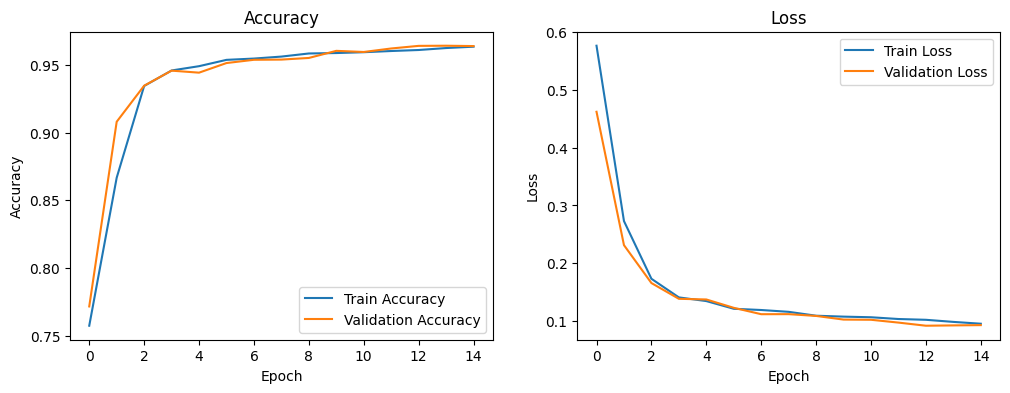

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show();

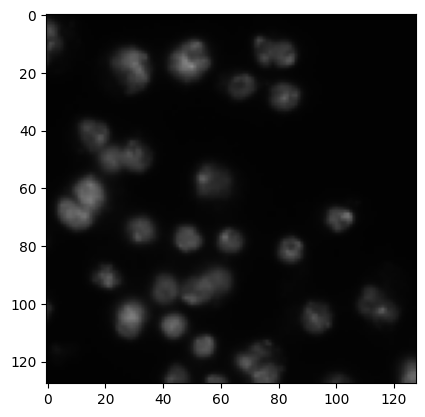

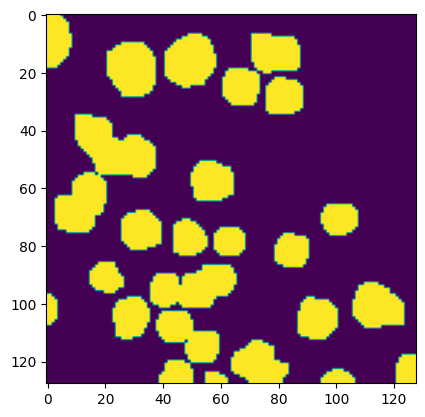

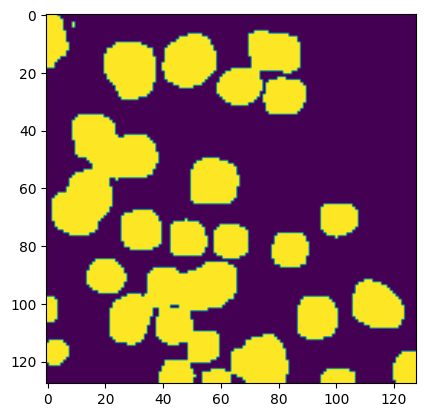

In [23]:
image_x = random.randint(0, len(train_pred_t))
plt.imshow(X_train[image_x])
plt.show();

plt.imshow(np.squeeze(y_train[image_x]))
plt.show();

plt.imshow(np.squeeze(train_pred_t[image_x]))
plt.show();

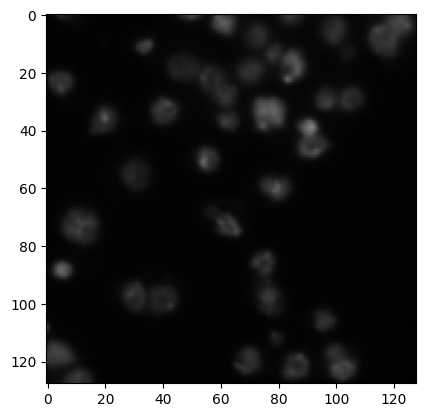

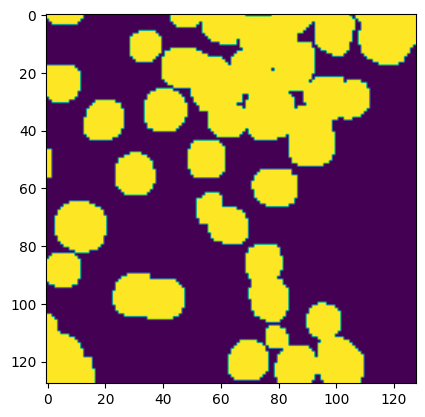

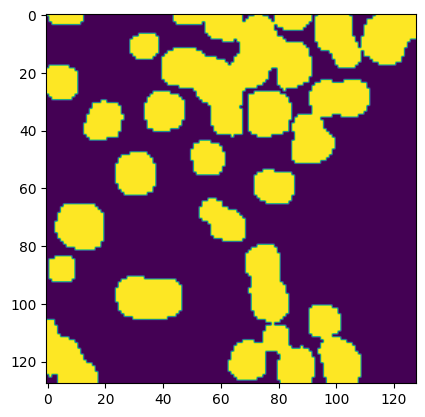

In [24]:
image_x = random.randint(0, len(val_pred_t))
plt.imshow(X_train[int(X_train.shape[0] * 0.9) + image_x])
plt.show();

plt.imshow(np.squeeze(y_train[int(X_train.shape[0] * 0.9) + image_x]))
plt.show();

plt.imshow(np.squeeze(val_pred_t[image_x]))
plt.show();

## **Saving the Model**
>Save the trained U-Net model in .keras format for reuse.

In [26]:
model.save('cell_segmentation_model.keras')